**Phu Nguyen, Sean Nightingale**

Imports

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, PrecisionRecallDisplay, RocCurveDisplay
from sklearn.preprocessing import LabelEncoder
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from xgboost import XGBClassifier

**Just some cells to help understand our data**

In [25]:
df = pd.read_csv("Dataset/diabetes_prediction_dataset.csv")
print(df.head())
print(df.info())
print(df.describe())


   gender   age  hypertension  heart_disease smoking_history    bmi  \
0  Female  80.0             0              1           never  25.19   
1  Female  54.0             0              0         No Info  27.32   
2    Male  28.0             0              0           never  27.32   
3  Female  36.0             0              0         current  23.45   
4    Male  76.0             1              1         current  20.14   

   HbA1c_level  blood_glucose_level  diabetes  
0          6.6                  140         0  
1          6.6                   80         0  
2          5.7                  158         0  
3          5.0                  155         0  
4          4.8                  155         0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  object 
 1   age               

In [26]:
# Replace 'No Info' with 'never' for age ≤ 5
df.loc[(df['age'] <= 5) & (df['smoking_history'] == 'No Info'), 'smoking_history'] = 'never'

# Display for confirmation
print(df[df['age'] <= 5])  # to check the changes

       gender   age  hypertension  heart_disease smoking_history    bmi  \
21       Male  5.00             0              0           never  18.80   
24     Female  4.00             0              0           never  13.99   
35       Male  5.00             0              0           never  15.10   
41       Male  5.00             0              0           never  27.32   
49     Female  3.00             0              0           never  19.27   
...       ...   ...           ...            ...             ...    ...   
99911  Female  0.32             0              0           never  18.37   
99916  Female  1.48             0              0           never  27.32   
99933  Female  5.00             0              0           never  13.34   
99940    Male  2.00             0              0           never  16.86   
99996  Female  2.00             0              0           never  17.37   

       HbA1c_level  blood_glucose_level  diabetes  
21             6.2                   85        

**Preprocess Stuff**

In [27]:
df.isnull().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
smoking_history        0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
diabetes               0
dtype: int64

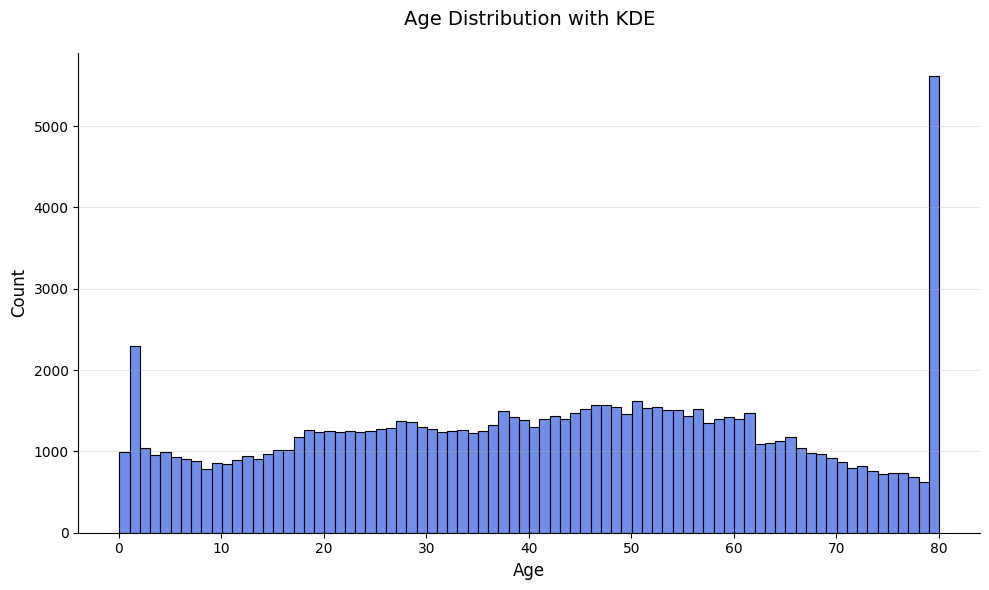

In [28]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df, 
             x='age', 
             bins=80,
             color='royalblue',
             edgecolor='black',
             linewidth=0.8)

plt.title('Age Distribution with KDE', 
          fontsize=14, 
          pad=20)
plt.xlabel('Age', fontsize=12)
plt.ylabel('Count', fontsize=12)
sns.despine()  # Remove top/right spines
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

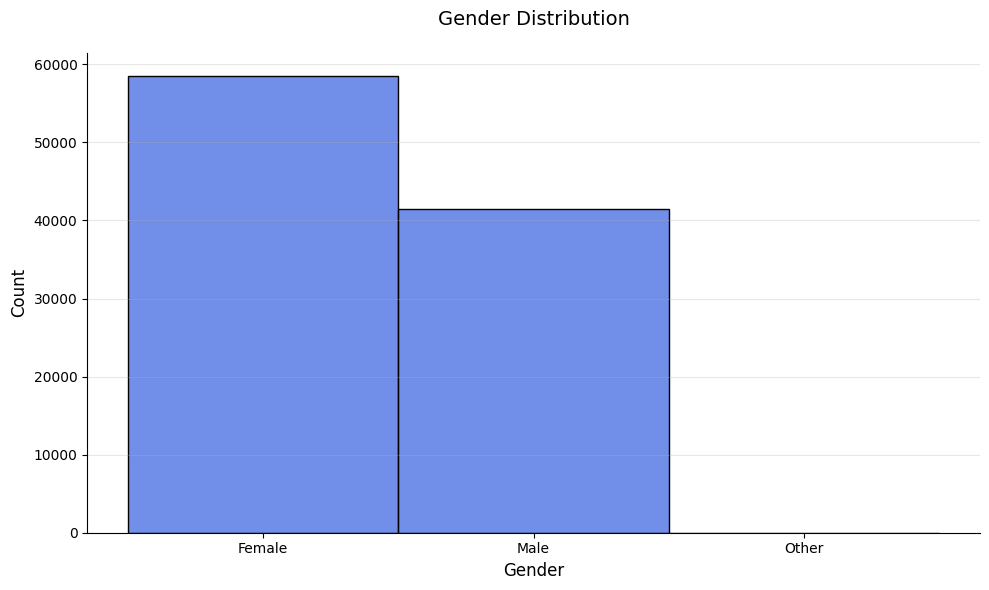

In [29]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df, 
             x='gender', 
             bins=3,
             color='royalblue',
             edgecolor='black',
             )

plt.title('Gender Distribution', 
          fontsize=14, 
          pad=20)
plt.xlabel('Gender', fontsize=12)
plt.ylabel('Count', fontsize=12)
sns.despine()  # Remove top/right spines
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

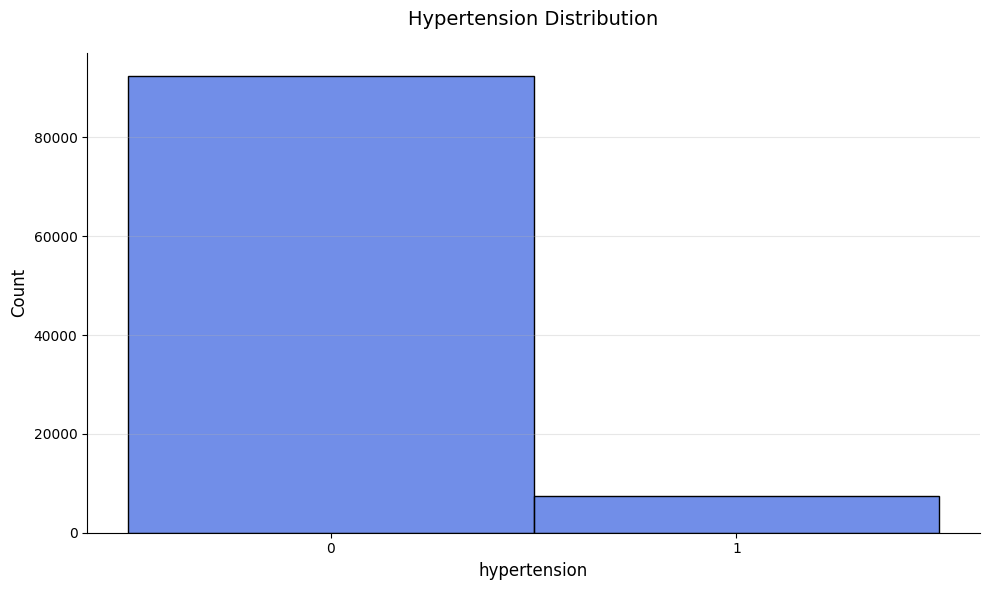

In [30]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df, 
             x='hypertension', 
             bins=[-0.5, 0.5, 1.5],
             color='royalblue',
             edgecolor='black',
             )

plt.title('Hypertension Distribution', 
          fontsize=14, 
          pad=20)
plt.xlabel('hypertension', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks([0, 1])
sns.despine()  # Remove top/right spines
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

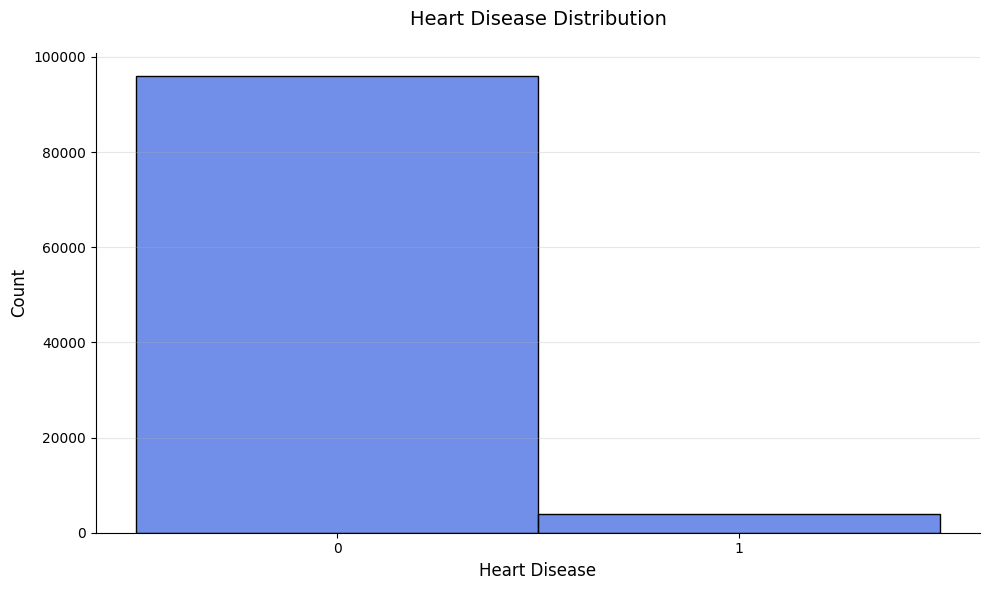

In [31]:
plt.figure(figsize=(10, 6))
ax = sns.histplot(data=df, 
             x='heart_disease', 
             bins=[-0.5, 0.5, 1.5],  # Explicit bin edges centered at 0 and 1
             color='royalblue',
             edgecolor='black',
             )

plt.title('Heart Disease Distribution', fontsize=14, pad=20)
plt.xlabel('Heart Disease', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks([0, 1]) 
sns.despine()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

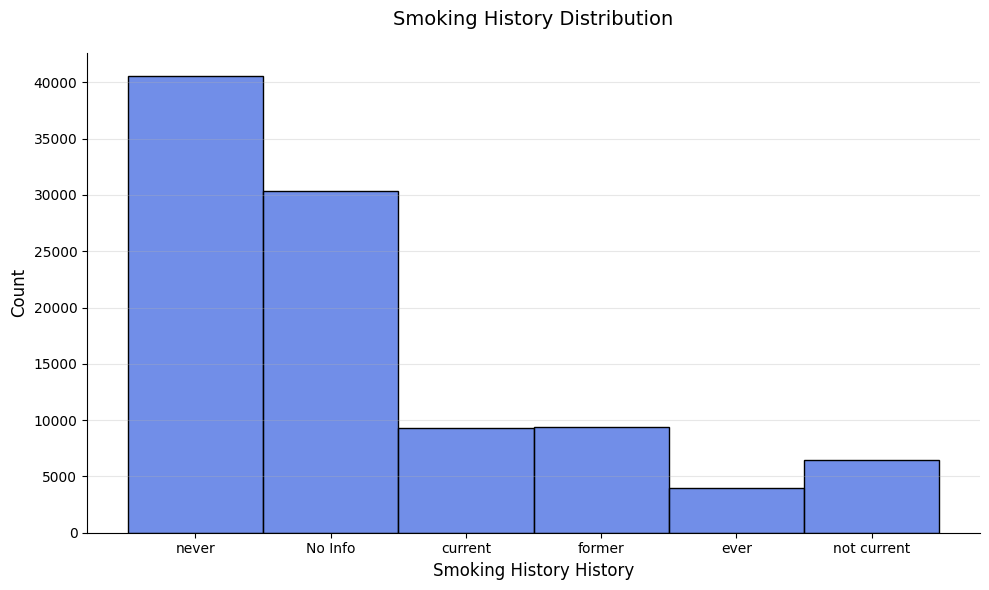

In [32]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df, 
             x='smoking_history', 
             bins=3,
             color='royalblue',
             edgecolor='black',
             )

plt.title('Smoking History Distribution', 
          fontsize=14, 
          pad=20)
plt.xlabel('Smoking History History', fontsize=12)
plt.ylabel('Count', fontsize=12)
sns.despine()  # Remove top/right spines
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

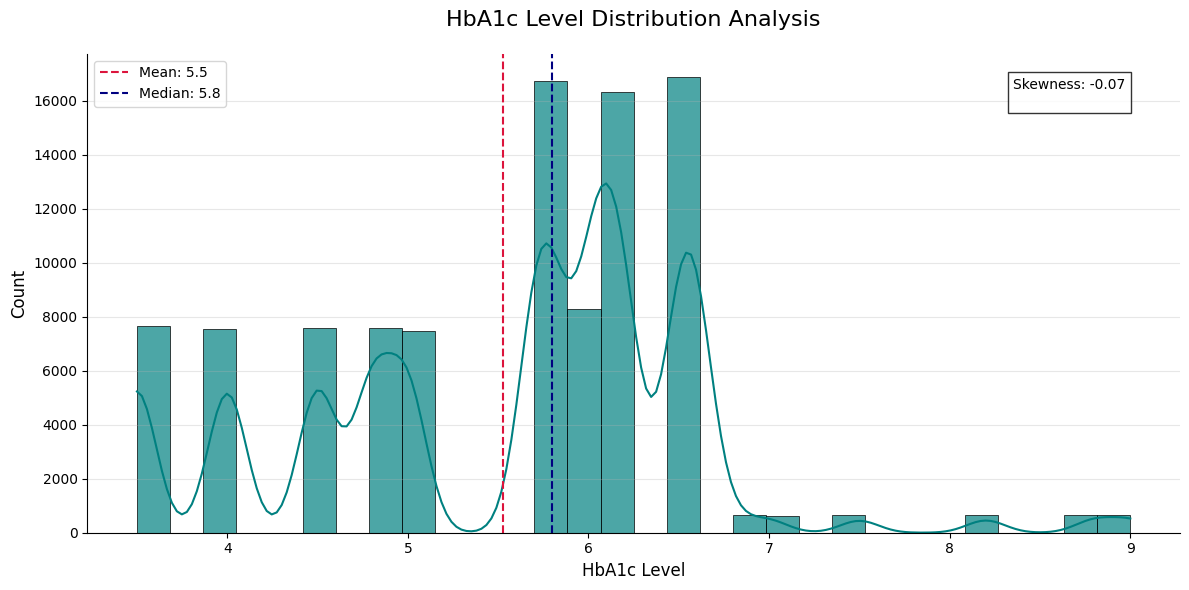

In [33]:
plt.figure(figsize=(12, 6))

# Create histogram with KDE
ax = sns.histplot(data=df,
                 x='HbA1c_level',
                 bins=30,  # Adjust number of bins for granularity
                 kde=True,
                 color='teal',
                 edgecolor='black',
                 alpha=0.7,
                 linewidth=0.5)

# Add vertical lines for mean and median
mean_HbA1c_level = df['HbA1c_level'].mean()
median_HbA1c_level = df['HbA1c_level'].median()
plt.axvline(mean_HbA1c_level, color='crimson', linestyle='--', linewidth=1.5, label=f'Mean: {mean_HbA1c_level:.1f}')
plt.axvline(median_HbA1c_level, color='navy', linestyle='--', linewidth=1.5, label=f'Median: {median_HbA1c_level:.1f}')

# Add annotations
plt.text(0.95, 0.95, 
        f'Skewness: {df["HbA1c_level"].skew():.2f}\n',
        transform=ax.transAxes,
        ha='right', va='top',
        bbox=dict(facecolor='white', alpha=0.8))

plt.title('HbA1c Level Distribution Analysis', fontsize=16, pad=20)
plt.xlabel('HbA1c Level', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.legend()
sns.despine()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

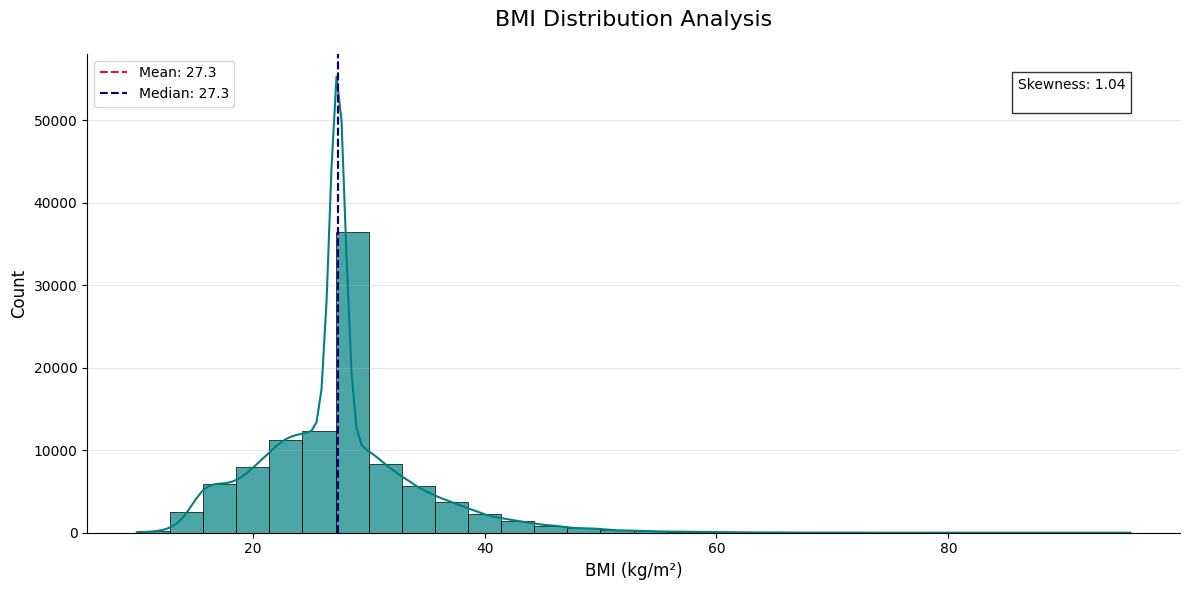

In [34]:
plt.figure(figsize=(12, 6))

# Create histogram with KDE
ax = sns.histplot(data=df,
                 x='bmi',
                 bins=30,  # Adjust number of bins for granularity
                 kde=True,
                 color='teal',
                 edgecolor='black',
                 alpha=0.7,
                 linewidth=0.5)

# Add vertical lines for mean and median
mean_bmi = df['bmi'].mean()
median_bmi = df['bmi'].median()
plt.axvline(mean_bmi, color='crimson', linestyle='--', linewidth=1.5, label=f'Mean: {mean_bmi:.1f}')
plt.axvline(median_bmi, color='navy', linestyle='--', linewidth=1.5, label=f'Median: {median_bmi:.1f}')

# Add annotations
plt.text(0.95, 0.95, 
        f'Skewness: {df["bmi"].skew():.2f}\n',
        transform=ax.transAxes,
        ha='right', va='top',
        bbox=dict(facecolor='white', alpha=0.8))

plt.title('BMI Distribution Analysis', fontsize=16, pad=20)
plt.xlabel('BMI (kg/m²)', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.legend()
sns.despine()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

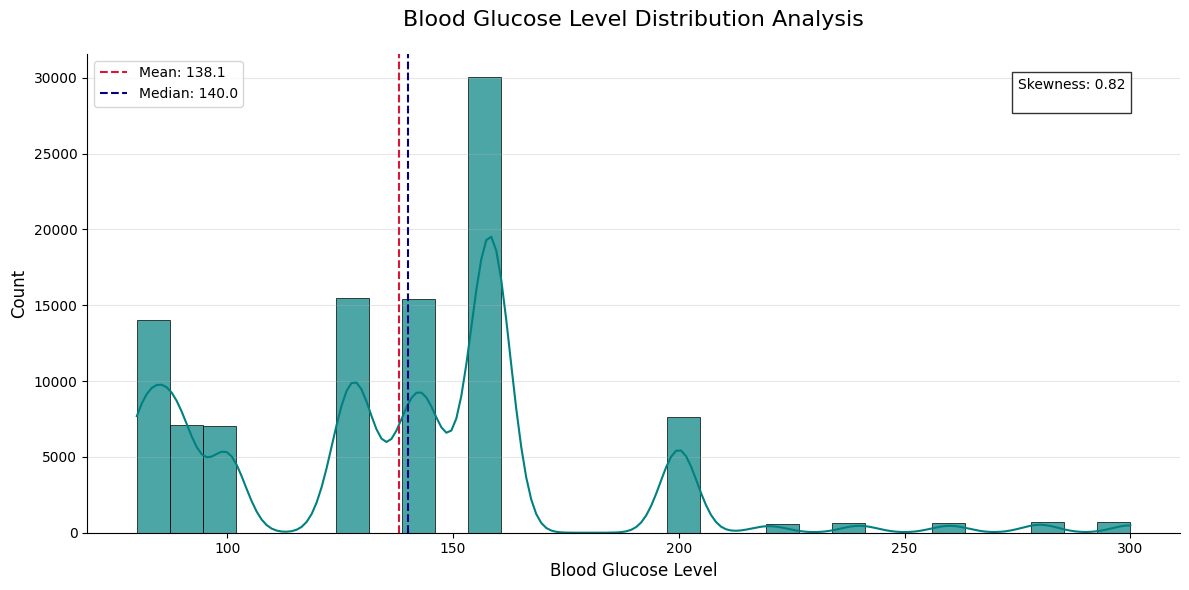

In [35]:
plt.figure(figsize=(12, 6))

# Create histogram with KDE
ax = sns.histplot(data=df,
                 x='blood_glucose_level',
                 bins=30,  # Adjust number of bins for granularity
                 kde=True,
                 color='teal',
                 edgecolor='black',
                 alpha=0.7,
                 linewidth=0.5)

# Add vertical lines for mean and median
mean_blood_glucose_level = df['blood_glucose_level'].mean()
median_blood_glucose_level = df['blood_glucose_level'].median()
plt.axvline(mean_blood_glucose_level, color='crimson', linestyle='--', linewidth=1.5, label=f'Mean: {mean_blood_glucose_level:.1f}')
plt.axvline(median_blood_glucose_level, color='navy', linestyle='--', linewidth=1.5, label=f'Median: {median_blood_glucose_level:.1f}')

# Add annotations
plt.text(0.95, 0.95, 
        f'Skewness: {df["blood_glucose_level"].skew():.2f}\n',
        transform=ax.transAxes,
        ha='right', va='top',
        bbox=dict(facecolor='white', alpha=0.8))

plt.title('Blood Glucose Level Distribution Analysis', fontsize=16, pad=20)
plt.xlabel('Blood Glucose Level', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.legend()
sns.despine()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

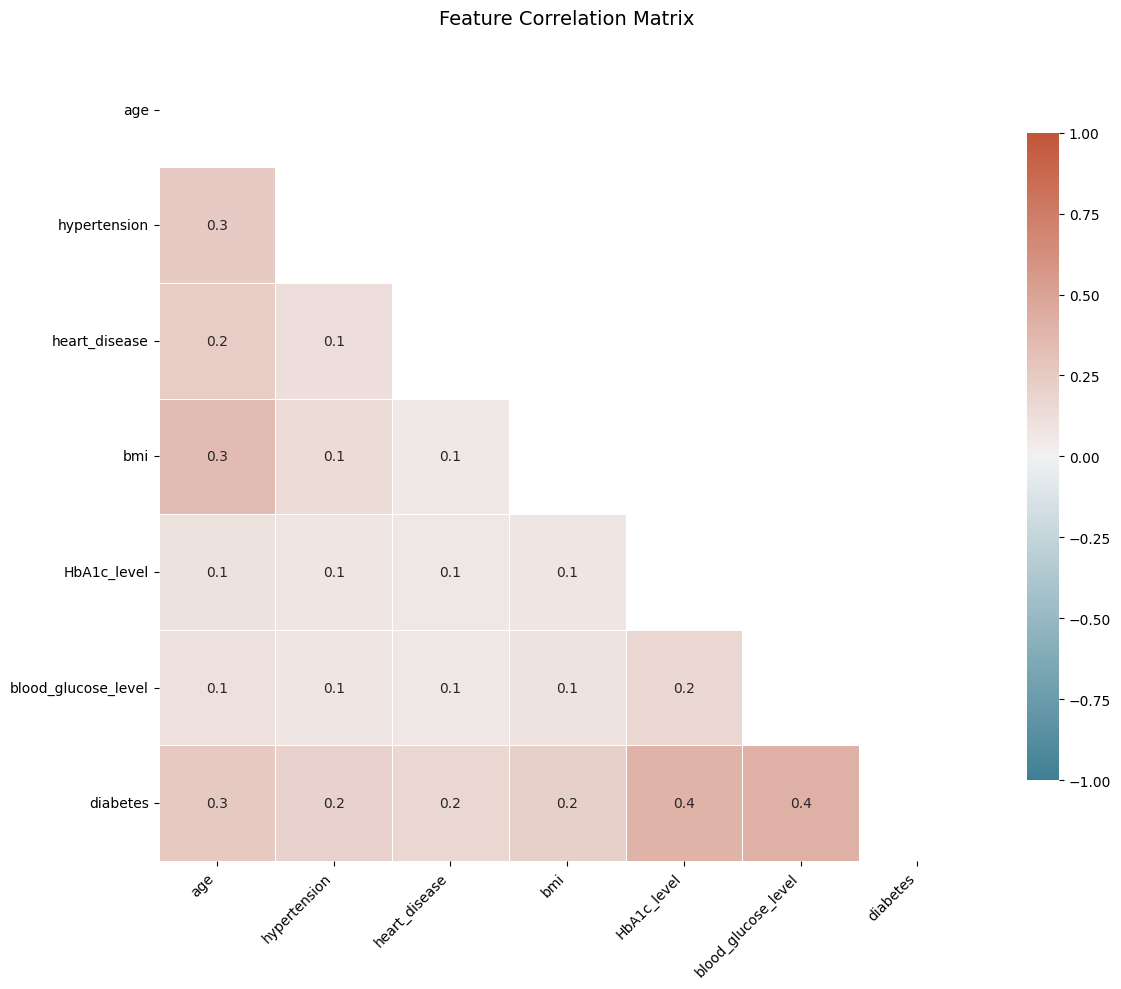

In [36]:
plt.figure(figsize=(12, 10))

# Calculate correlations
numeric_df = df.select_dtypes(include=['int64', 'float64'])

corr_matrix = numeric_df.corr()

# Create mask for upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Custom color map
cmap = sns.diverging_palette(220, 20, as_cmap=True)

# Generate heatmap
ax = sns.heatmap(corr_matrix,
                 mask=mask,
                 cmap=cmap,
                 vmin=-1, vmax=1,
                 center=0,
                 annot=True,
                 fmt=".1f",
                 linewidths=0.5,
                 annot_kws={"size": 10},
                 cbar_kws={"shrink": 0.8})

# Improve readability
plt.title("Feature Correlation Matrix", fontsize=14, pad=20)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

# Remove empty space
plt.tight_layout()
plt.show()

**Data Splitting**

In [37]:
le = LabelEncoder()
categorical_cols = df.select_dtypes(include=['object', 'string']).columns
for col in categorical_cols:
    df[col] = le.fit_transform(df[col])


X = df.drop('diabetes', axis=1)  # Replace with your target column name
y = df['diabetes']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


**DECISION TREE CLASSIFIER**

In [38]:
clf = DecisionTreeClassifier(
    max_depth=20,  # Control tree depth to prevent overfitting
    min_samples_split=20,
    criterion='gini',  # or 'entropy'
    class_weight={0:1, 1:5}, # Adding class weight to prioritize minority class
    random_state=42
)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

class_names = ["No Diabetes", "Diabetes"]
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

 No Diabetes       0.98      0.95      0.96     18292
    Diabetes       0.59      0.82      0.69      1708

    accuracy                           0.94     20000
   macro avg       0.79      0.88      0.83     20000
weighted avg       0.95      0.94      0.94     20000



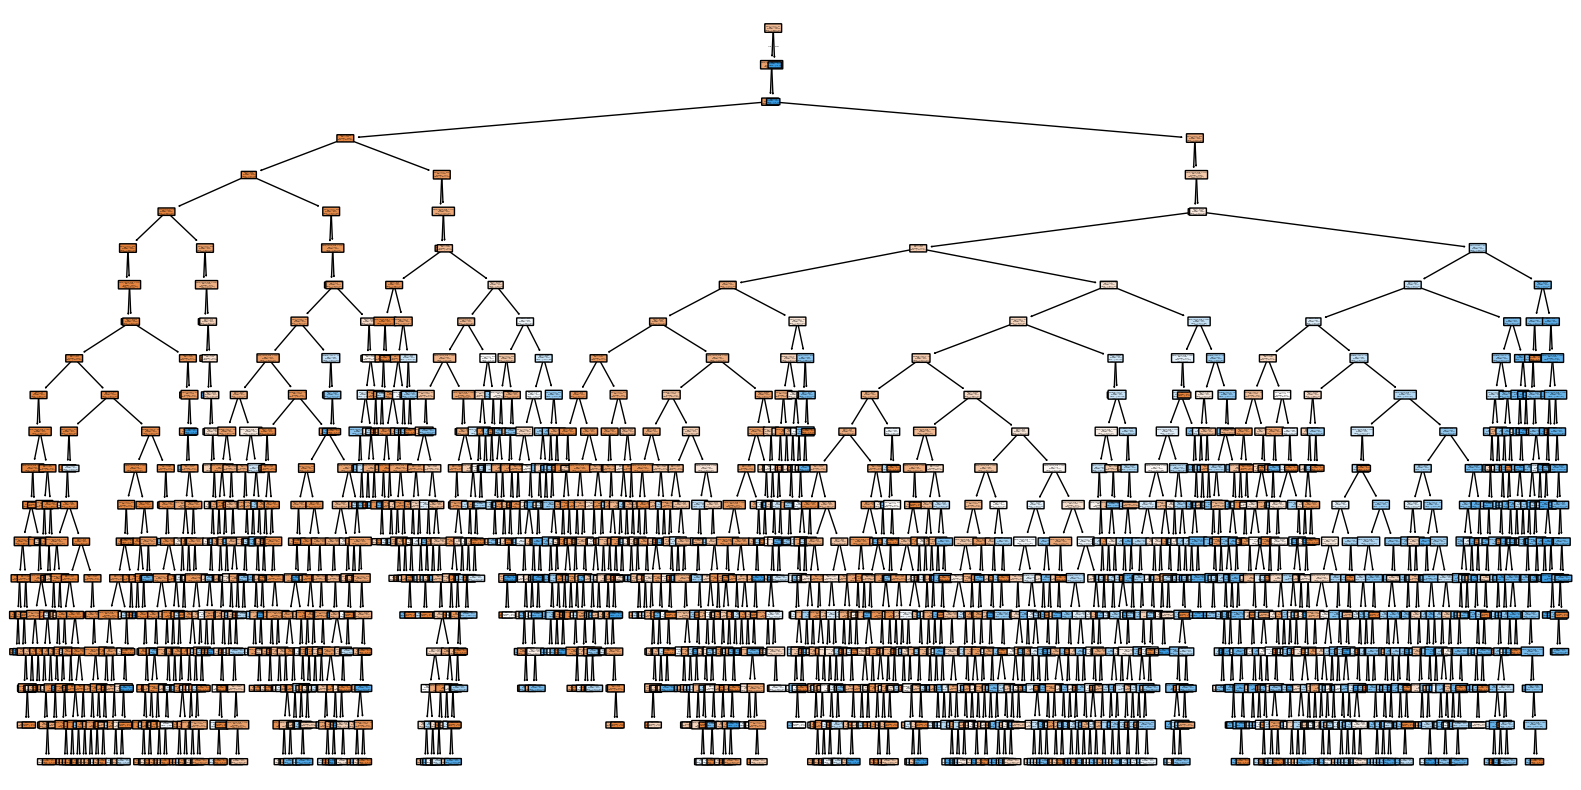

In [39]:
plt.figure(figsize=(20,10))
plot_tree(clf,
          feature_names=X.columns,
          class_names=le.classes_ if categorical_cols.any() else None,
          filled=True,
          rounded=True,
          proportion=True)
plt.show()

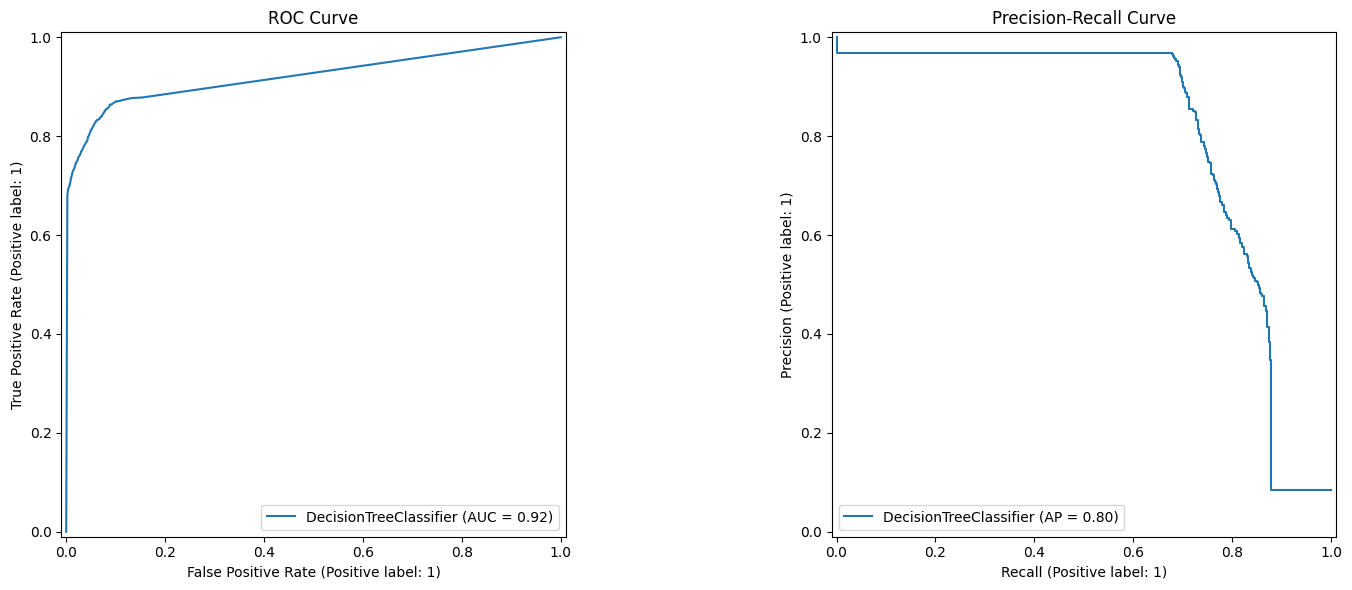

In [40]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# ROC Curve
RocCurveDisplay.from_estimator(clf, X_test, y_test, ax=ax1)
ax1.set_title('ROC Curve')

# Precision-Recall Curve
PrecisionRecallDisplay.from_estimator(clf, X_test, y_test, ax=ax2)
ax2.set_title('Precision-Recall Curve')

plt.tight_layout()
plt.show()

In [41]:
path = clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = path.ccp_alphas

param_grid = {
    'max_depth': [3, 7, 10],
    'min_samples_split': [2, 5, 10],
    'criterion': ['gini', 'entropy'],
    'class_weight': [{0:1, 1:5}, {0:1, 1:6}, 'balanced'],
}

scoring = {
    'f1': 'f1',
    'recall': 'recall',
    'roc_auc': 'roc_auc',
}

grid_search = GridSearchCV(estimator=clf,
                          param_grid=param_grid,
                          cv=5,
                          n_jobs=-1,
                          scoring=scoring,
                          refit='recall')
grid_search.fit(X_train, y_train)

best_clf = grid_search.best_estimator_
print(f"Best parameters: {grid_search.best_params_}")

Best parameters: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 7, 'min_samples_split': 2}


In [42]:
clf = DecisionTreeClassifier(
    max_depth=7,  # Control tree depth to prevent overfitting
    min_samples_split=2,
    criterion='entropy',  # or 'entropy'
    class_weight='balanced', # Adding class weight to prioritize minority class
    random_state=42
)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

class_names = ["No Diabetes", "Diabetes"]
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

 No Diabetes       0.99      0.89      0.94     18292
    Diabetes       0.43      0.91      0.59      1708

    accuracy                           0.89     20000
   macro avg       0.71      0.90      0.76     20000
weighted avg       0.94      0.89      0.91     20000



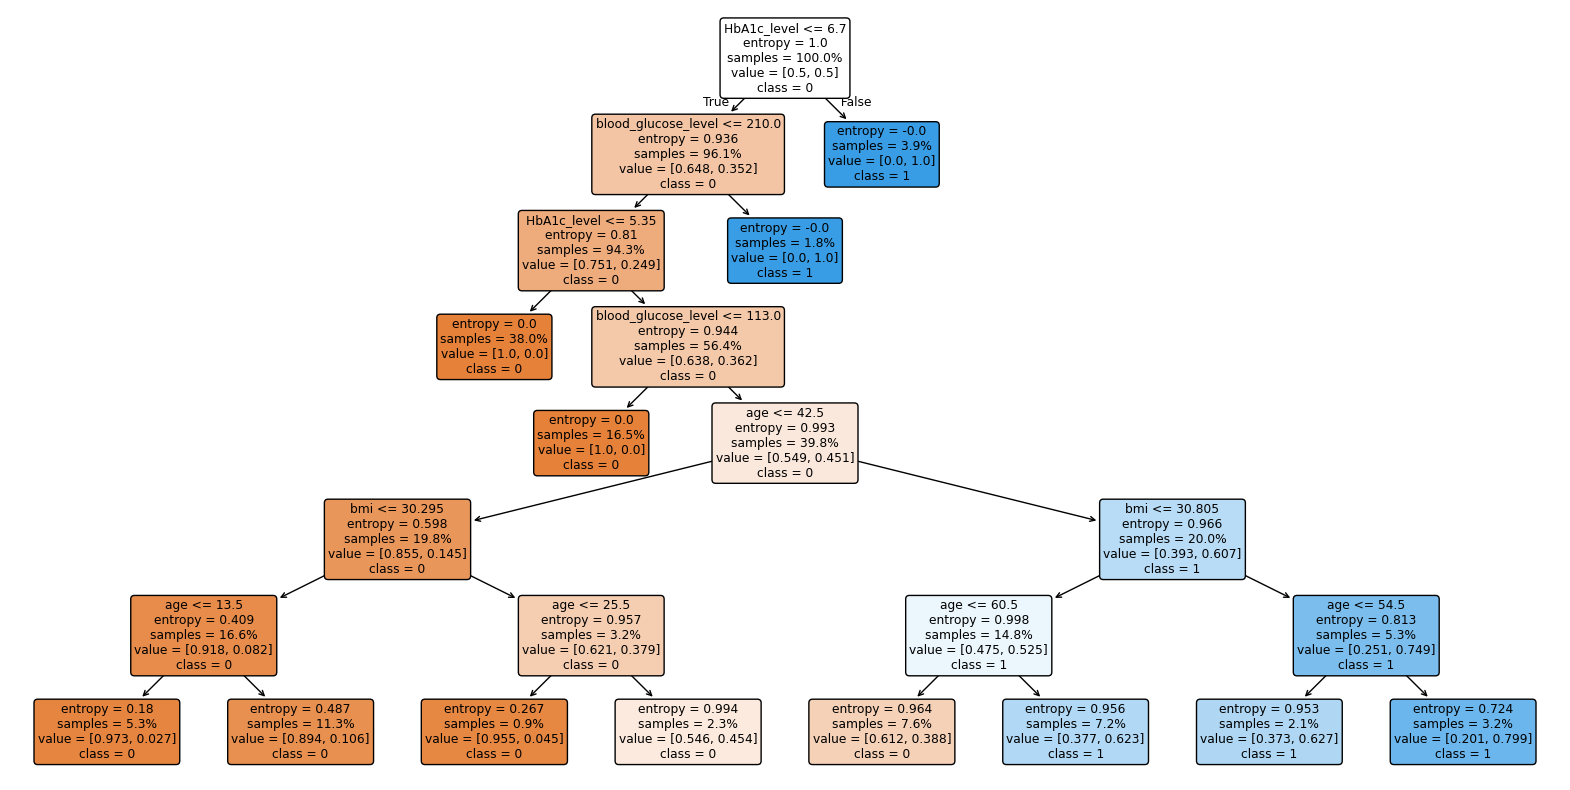

In [44]:
plt.figure(figsize=(20,10))
plot_tree(clf,
          feature_names=X.columns,
          class_names=[str(c) for c in df['diabetes'].unique()] if categorical_cols.any() else None,
          filled=True,
          rounded=True,
          proportion=True)
plt.show()


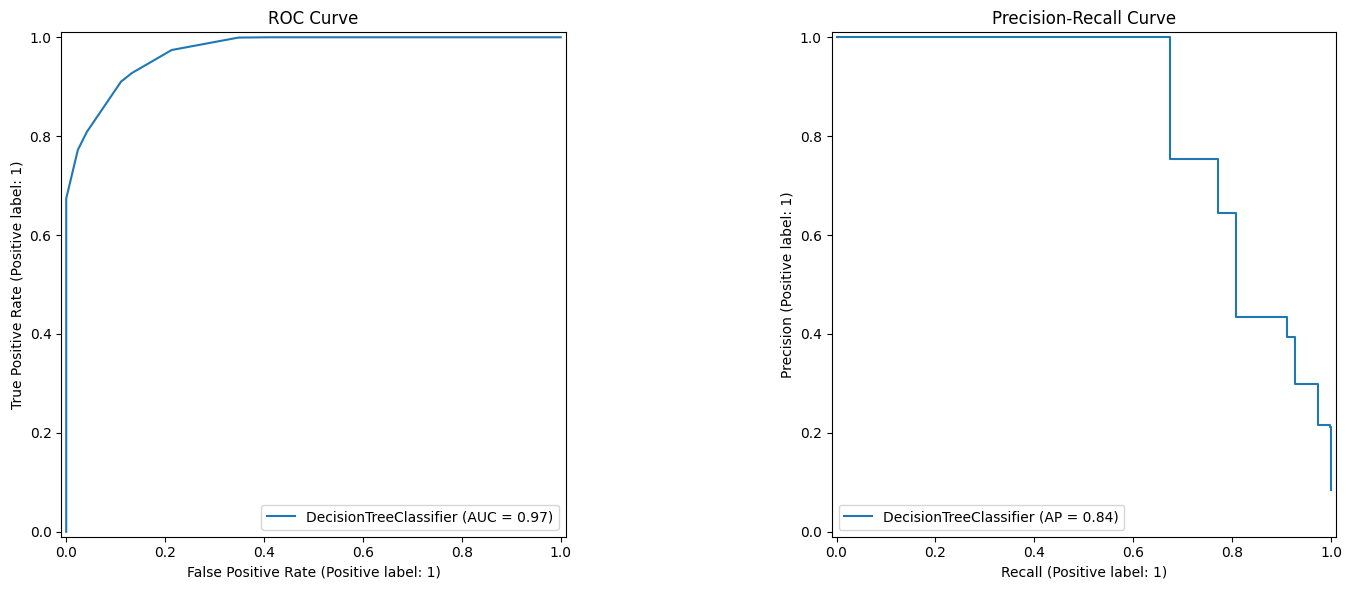

In [45]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# ROC Curve
RocCurveDisplay.from_estimator(clf, X_test, y_test, ax=ax1)
ax1.set_title('ROC Curve')

# Precision-Recall Curve
PrecisionRecallDisplay.from_estimator(clf, X_test, y_test, ax=ax2)
ax2.set_title('Precision-Recall Curve')

plt.tight_layout()
plt.show()

**ENSEMBLE CLASSIFIER**

In [ ]:
# Base models
base_models = [
    ('rf', RandomForestClassifier(class_weight='balanced', random_state=42)),
    ('xgb', XGBClassifier(scale_pos_weight=len(y_train[y_train==0])/len(y_train[y_train==1])))
]

# Ensemble pipeline
ensemble_pipe = Pipeline([
    ('smote', SMOTE(random_state=42)),  # Optional: remove if not needed
    ('stack', StackingClassifier(
        estimators=base_models,
        final_estimator=XGBClassifier(),
        stack_method='predict_proba',
        passthrough=True
    ))
])

ensemble_pipe.fit(X_train, y_train)

y_pred = clf.predict(X_test)

class_names = ["No Diabetes", "Diabetes"]
print(classification_report(y_test, y_pred, target_names=class_names))

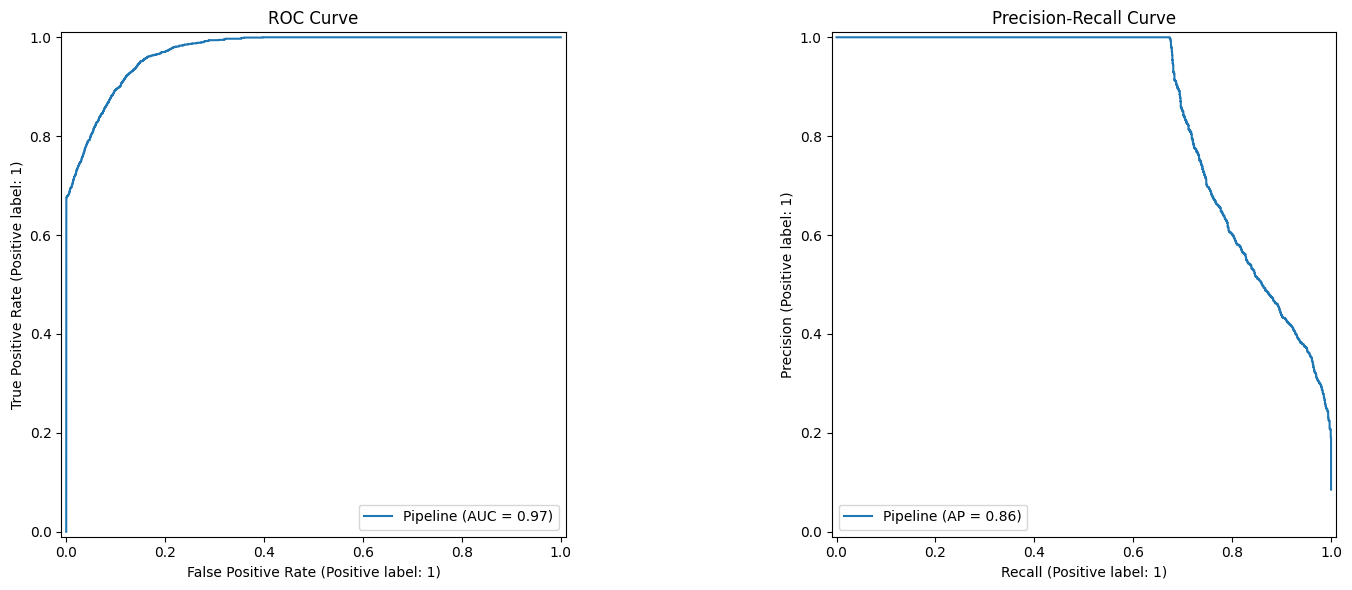

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# ROC Curve
RocCurveDisplay.from_estimator(ensemble_pipe, X_test, y_test, ax=ax1)
ax1.set_title('ROC Curve')

# Precision-Recall Curve
PrecisionRecallDisplay.from_estimator(ensemble_pipe, X_test, y_test, ax=ax2)
ax2.set_title('Precision-Recall Curve')

plt.tight_layout()
plt.show()

In [ ]:
param_grid = {
    'smote__k_neighbors': [3, 5],  # SMOTE parameters
    'stack__rf__max_depth': [5, 7],
    'stack__xgb__learning_rate': [0.05, 0.1],
    'stack__final_estimator__max_depth': [3, 5]
}

scoring = {
    # 'f1': 'f1',
    'recall': 'recall',
    # 'roc_auc': 'roc_auc',
}

grid = GridSearchCV(
    ensemble_pipe,
    param_grid,
    scoring=scoring,
    refit='recall',
    cv=5,
    n_jobs=-1,
    verbose=2
)

grid.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('smote', SMOTE(random_state=42)),
                                       ('stack',
                                        StackingClassifier(estimators=[('rf',
                                                                        RandomForestClassifier(class_weight='balanced',
                                                                                               random_state=42)),
                                                                       ('xgb',
                                                                        XGBClassifier(base_score=None,
                                                                                      booster=None,
                                                                                      callbacks=None,
                                                                                      colsample_bylevel=None,
                                                                                      colsample_bynode=None,
                                                                                      colsample_bytree=None,
                                                                                      device='cuda',
                                                                                      early_stopping_r...
                                                                                         max_cat_threshold=None,
                                                                                         max_cat_to_onehot=None,
                                                                                         max_delta_step=None,
                                                                                         max_depth=None,
                                                                                         max_leaves=None,
                                                                                         min_child_weight=None,
                                                                                         missing=nan,
                                                                                         monotone_constraints=None,
                                                                                         multi_strategy=None,
                                                                                         n_estimators=None,
                                                                                         n_jobs=None,
                                                                                         num_parallel_tree=None, ...),
                                                           passthrough=True,
                                                           stack_method='predict_proba'))]),
             n_jobs=-1, param_grid={}, refit='recall',
             scoring={'f1': 'f1', 'recall': 'recall'}, verbose=2)

In [ ]:
best_model = grid.best_estimator_
print(f"Best Parameters: {grid.best_params_}")

Best Parameters: {}


In [ ]:
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98     18292
           1       0.91      0.69      0.78      1708

    accuracy                           0.97     20000
   macro avg       0.94      0.84      0.88     20000
weighted avg       0.97      0.97      0.97     20000



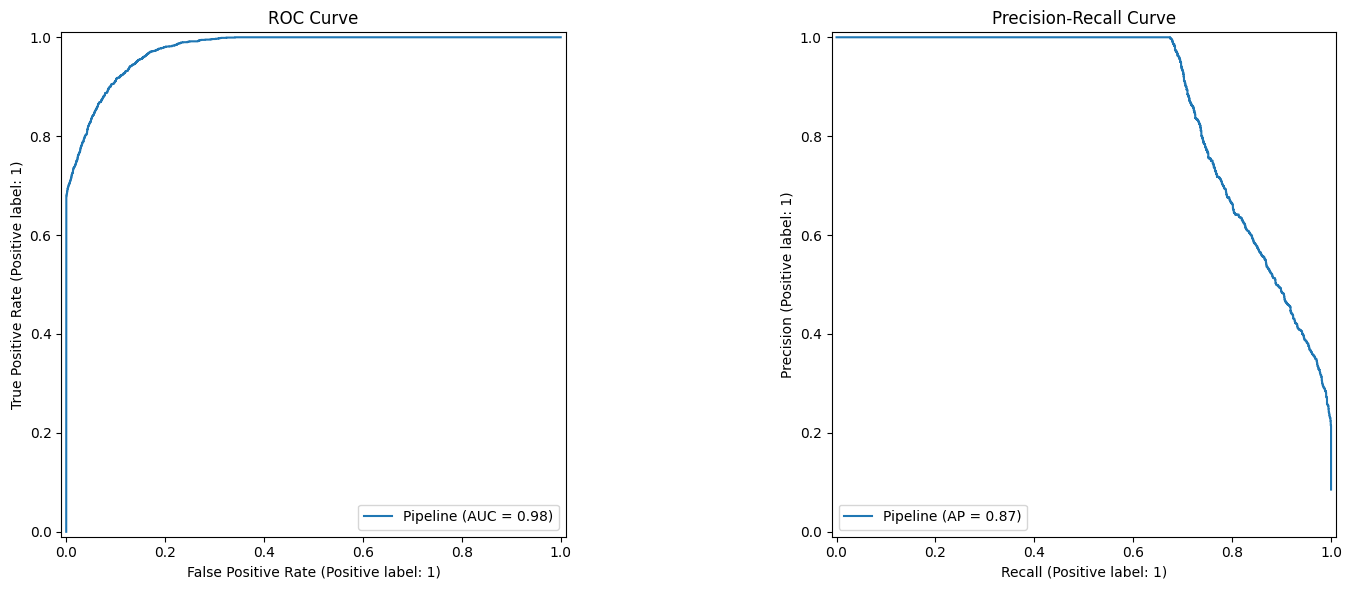

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# ROC Curve
RocCurveDisplay.from_estimator(best_model, X_test, y_test, ax=ax1)
ax1.set_title('ROC Curve')

# Precision-Recall Curve
PrecisionRecallDisplay.from_estimator(best_model, X_test, y_test, ax=ax2)
ax2.set_title('Precision-Recall Curve')

plt.tight_layout()
plt.show()